# Вступление

___

Для тренировки модели необходимо для начала подготовить данные. Для работы с данными хорошо подходят библиотеки: numpy, pandas и matplotlib.

Для начала импортируем эти библиотеки.

В дальнейшем в этот блок кода будем добавлять и другие библиотеки по мере необходимости

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Загрузка данных

Поскольку данные представлены в табличном формате удобнее всего с ними работать в виде датафрейма pandas. Файл с данными достаточно большой, поэтому предварительное его рекомендуется загрузить на гугл диск. Google Colab хорошо работает с гугл диском, поэтому смонтируем его в ноутбук

In [3]:
drive.mount('/content/drive')
path_to_dir = '/content/drive/MyDrive/Colab Notebooks/spam_filter_vk'
name_dataset_train = 'train_spam.csv'
name_dataset_test = 'test_spam.csv'
df_train = pd.read_csv('/'.join([path_to_dir, name_dataset_train]))
df_test = pd.read_csv('/'.join([path_to_dir, name_dataset_test]))

Mounted at /content/drive


Изучение данных
Дальше необходимо понять что из себя представляют данные
Посмотрим на train

In [4]:
print(df_train.head(10))
print(df_train.shape)
print(df_train.dtypes.value_counts())

  text_type                                               text
0       ham  make sure alex knows his birthday is over in f...
1       ham  a resume for john lavorato thanks vince i will...
2      spam  plzz visit my website moviesgodml to get all m...
3      spam  urgent your mobile number has been awarded wit...
4       ham  overview of hr associates analyst project per ...
5      spam  i am so greatful to mrs valerie dodson for hel...
6       ham  url url date not supplied government employees...
7      spam  welcome to jefferson pilot s gateway to wealth...
8       ham  looks like your ham corpus by and large has to...
9       ham  how are you with moneyas in to youmoney aint a...
(16278, 2)
object    2
Name: count, dtype: int64


В тренировочном датасете 16278 записей. Каждая запись представляет из себя текст сообщения и метку spam (спам) или ham (не спам)

Посмотрим на test

In [5]:
print(df_test.head(10))
print(df_test.shape)
print(df_test.dtypes.value_counts())

                                                text
0  j jim whitehead ejw cse ucsc edu writes j you ...
1  original message from bitbitch magnesium net p...
2  java for managers vince durasoft who just taug...
3               there is a youtuber name saiman says
4  underpriced issue with high return on equity t...
5                          aight lemme know whats up
6  hey girl how r u hope u r well me an del r bak...
7  carnegie mellon recruiting good afternoon i ha...
8  cv of rodney greene re quantitative positions ...
9  i cant able to cos of me he drunk today im rea...
(4070, 1)
object    1
Name: count, dtype: int64


В тестовом датасете 4070 сообщений, необходимо их отфильтровать на спам и не спам

Проанализируем как распределены классы спам и не спам в тренировочном датасете

In [6]:
print(df_train['text_type'].value_counts())

text_type
ham     11469
spam     4809
Name: count, dtype: int64


Сообщений с пометкой спам примерно в 2 раза меньше, чем полезных

Посмотрим на распределение длин сообщений по количеству символов


Распределение тренировочной выборки

Минимальная длина сообщения 1
Максимальная длина сообщения 800
Средняя длина сообщения 310.3835237744195
Медиана длин сообщений 157.0


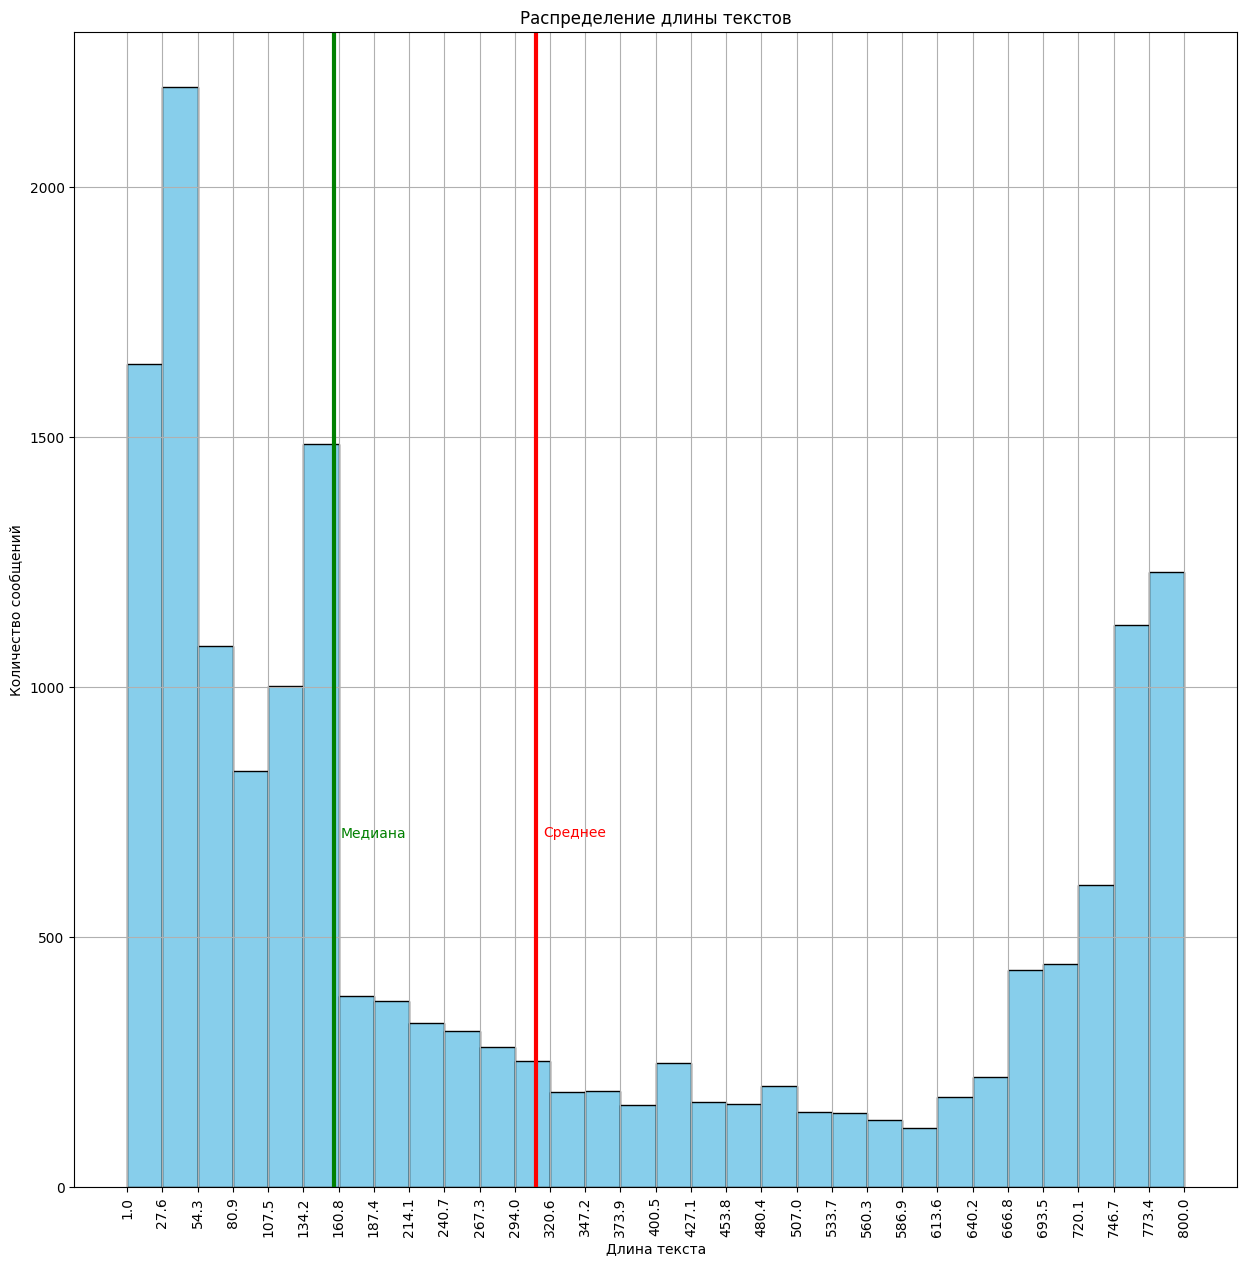


Распределение тестовой выборки

Минимальная длина сообщения 2
Максимальная длина сообщения 800
Средняя длина сообщения 313.03562653562653
Медиана длин сообщений 158.0


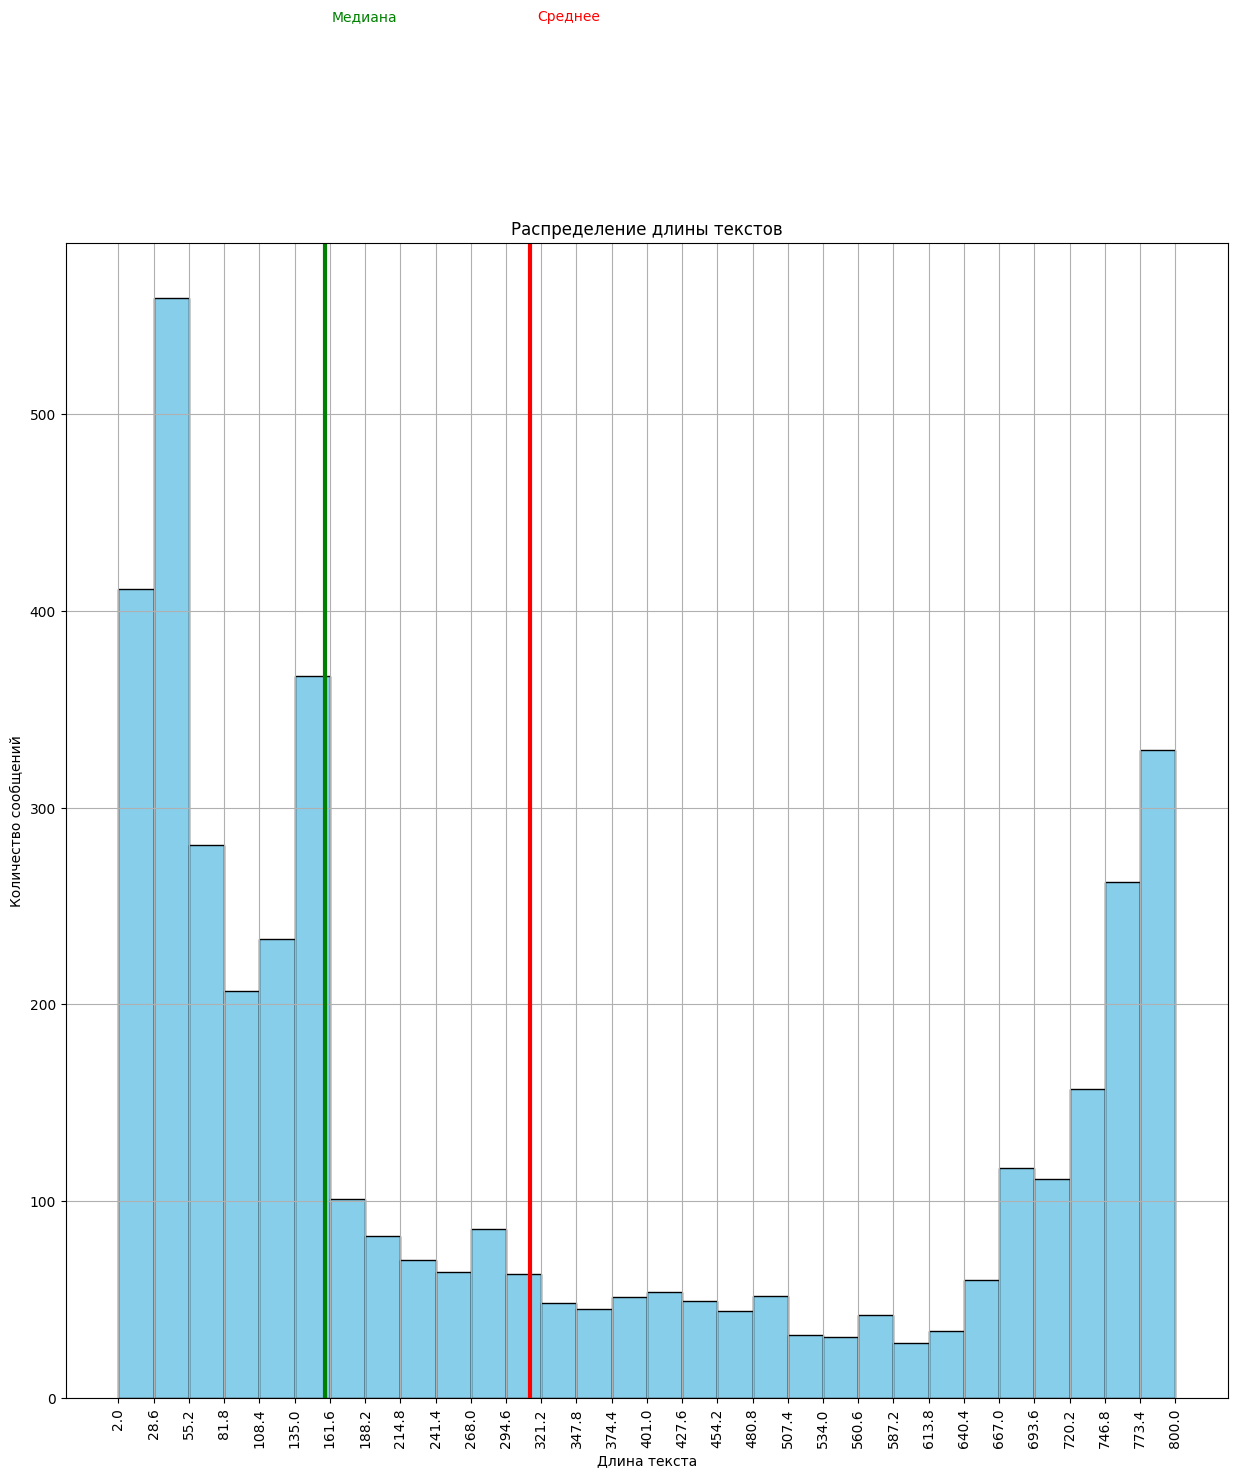

In [7]:
def len_distribution(df):
    text_len = df['text'].apply(len)
    print(f'Минимальная длина сообщения {text_len.min()}')
    print(f'Максимальная длина сообщения {text_len.max()}')
    print(f'Средняя длина сообщения {text_len.mean()}')
    print(f'Медиана длин сообщений {text_len.median()}')
    fig = plt.figure(figsize=(15, 15))
    bins = 30
    fig.add_subplot(1, 1, 1)
    plt.hist(text_len, bins=bins, color='skyblue', edgecolor='black')
    plt.axvline(text_len.mean(), color='red', linestyle='solid', linewidth=3)
    plt.text(text_len.mean() + 5, 700, f'Среднее', color='red')
    plt.axvline(text_len.median(), color='green', linestyle='solid', linewidth=3)
    plt.text(text_len.median() + 5, 700, f'Медиана', color='green')
    step = (text_len.max() - text_len.min()) / bins
    ticks = [text_len.min() + i * step for i in range(bins + 1)]
    plt.xticks(ticks, rotation=90)
    plt.title('Распределение длины текстов')
    plt.xlabel('Длина текста')
    plt.ylabel('Количество сообщений')
    plt.grid(True)
    plt.show()


print('\nРаспределение тренировочной выборки\n')
len_distribution(df_train)
print('\nРаспределение тестовой выборки\n')
len_distribution(df_test)

Распределения тренировочной и тестовой выборки очень похожи. Можно предположить, что данные для теста и трейна взяты из одного источника. Скорее всего текстовые сообщения в тесте и трейне очень похожи. Исходя из этого можно предположить что распределение на спам и не спам вполне вероятно будет аналогичным. К тому же научившись на тренировочных данных модель должна хорошо классифицировать представленные тестовые данные.

Интересно было бы еще посмотреть на распределения среди спам и не спам сообщений




Распределение не спам

Минимальная длина сообщения 1
Максимальная длина сообщения 800
Средняя длина сообщения 314.168279710524
Медиана длин сообщений 141.0


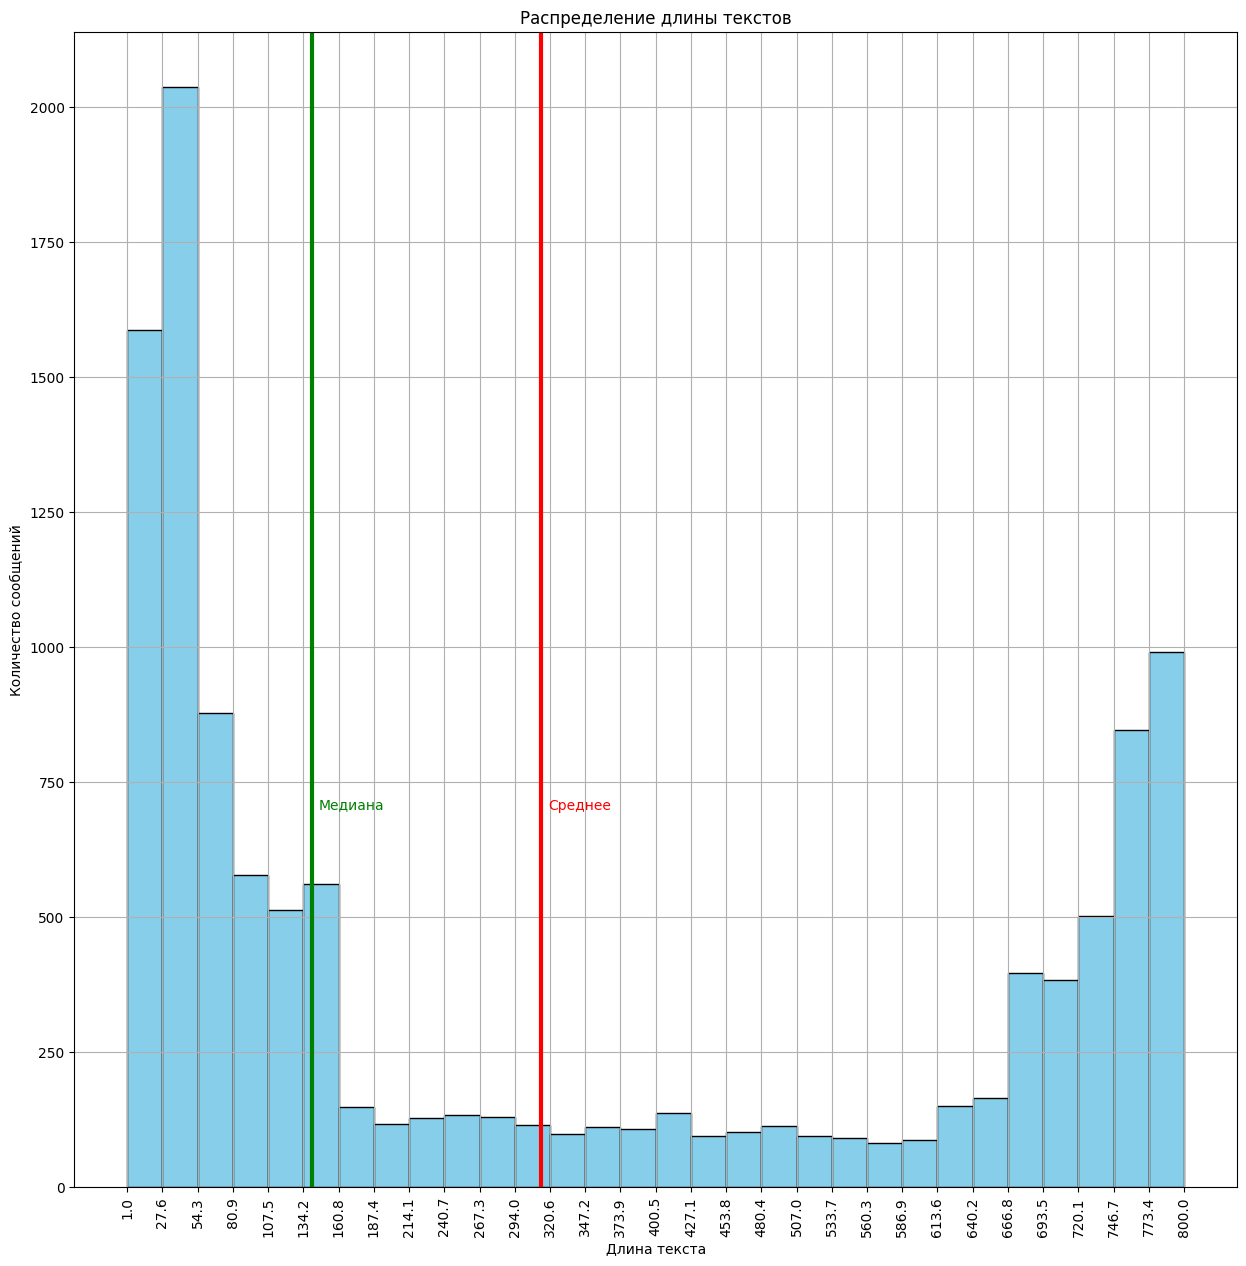


Распределение спам

Минимальная длина сообщения 5
Максимальная длина сообщения 800
Средняя длина сообщения 301.35724682886257
Медиана длин сообщений 195.0


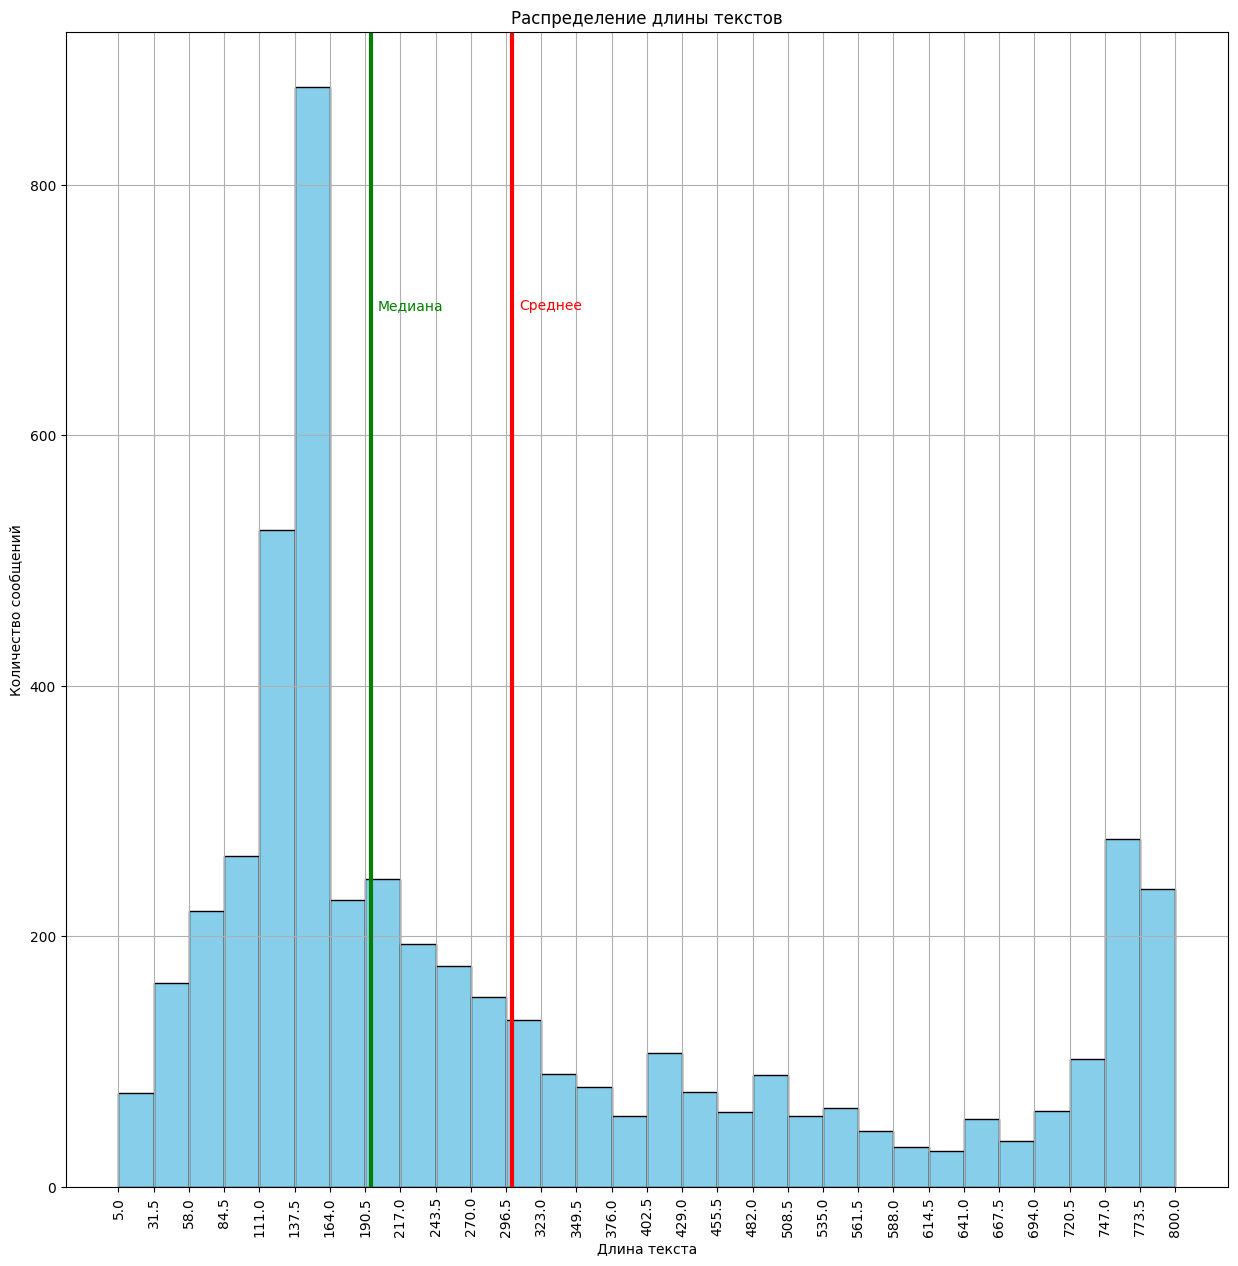

In [8]:
df_spam = df_train[df_train['text_type'] == 'spam']
df_ham = df_train[df_train['text_type'] == 'ham']
print('\nРаспределение не спам\n')
len_distribution(df_ham)
print('\nРаспределение спам\n')
len_distribution(df_spam)

Спам и не спам покрывают всю область распределения. Но в спаме преобладает длина сообщений от 110 до 164 символов, в свою очередь не спам сообщения в большей степени короче.

Сообщений средней длины не очень много, а вот длинных в 700-800 символов достаточно много как в классе спам так и в классе не спам.

Мне еще интересно посмотреть как делалась разметка на очень коротких сообщениях

In [9]:
df_short_spam = df_spam[df_spam['text'].apply(len) <= 20]
df_short_ham = df_ham[df_ham['text'].apply(len) <= 10]
print(df_short_spam.head(20))
print(df_short_ham.head(20))

      text_type                  text
320        spam      please subscribe
513        spam             subscribe
1630       spam         dm me sub for
2418       spam    massage me uc free
2571       spam                 links
2768       spam    ringtoneking 84484
3959       spam      noob£sneha sneha
4556       spam         ous/airy room
4765       spam             join karo
4900       spam        check this out
6609       spam          22 146tf150p
8814       spam             donate to
9160       spam      chocolate treat!
9209       spam              join now
9317       spam         ✅✅✅✅✅✅✅✅✅✅✅✅✅
9686       spam          i am spammer
9883       spam        dating online?
10084      spam      hi girls dmme😉 💰
10882      spam  💰 get app & win cash
11352      spam       free 100$ token
     text_type        text
76         ham      urgent
113        ham    im sorry
149        ham        fast
167        ham      yup ok
193        ham   free fire
233        ham        logs
331        ha

Похоже на правду. На очень коротких сообщениях достаточно хорошая разметка.

# Построение модели

Для начала необходимо преобразовать метки классов в числовой формат. Пусть спам будет с меткой 1, а не спам с меткой 0.

Также необходимо разделить данные на х и y, а также на обучающую и тестовую выборку

In [10]:
x_train, x_test, y_train, y_test = train_test_split(df_train['text'], df_train['text_type'], shuffle=True, test_size=0.2, random_state=42)
y_test = y_test.apply(lambda x: 1 if x == 'spam' else 0)
y_train = y_train.apply(lambda x: 1 if x == 'spam' else 0)

Проверим корректность работы кода

In [11]:
print(x_train.head())
print(x_train.shape)
print(x_test.head())
print(x_test.shape)
print(y_train.head())
print(y_train.shape)
print(y_test.head())
print(y_test.shape)

1157                           going to take your babe out
3474     ken attached is a correction to pages 10 11 an...
4084                            except android is a cucked
1383     stop been afraid stop the procrastination make...
14626    on aug 1635465 bort paul wrote if your sendmai...
Name: text, dtype: object
(13022,)
11533    pi is a new digital currency developed by stan...
5862     𝐼 𝑑𝑜 𝑏𝑒𝑙𝑒𝑖𝑣𝑒 𝑜𝑛 𝑓𝑜𝑟𝑒𝑥 𝑡𝑟𝑎𝑑𝑒 𝑎𝑓𝑡𝑒𝑟 𝑚𝑦 𝑤𝑖𝑡ℎ𝑑𝑟𝑎𝑤𝑎...
123      when i earn my first $10000 on forex trade it ...
2771     i dnt knw jab tayaar houngi tab bta dungi nd j...
8246                                who told dis? naam bta
Name: text, dtype: object
(3256,)
1157     0
3474     0
4084     0
1383     1
14626    0
Name: text_type, dtype: int64
(13022,)
11533    1
5862     1
123      1
2771     0
8246     0
Name: text_type, dtype: int64
(3256,)


Модели машинного обучения работают только с цифрами, поэтому необходимо сделать векторизацию данных. Существует множество подходов к решению данной задаче.

Наиболее простым считается Count Vectorizer. В котором мы создаем словарь из всех имеющихся у нас уникальных слов, а после для каждого сообщения считаем сколько раз слова из словоря встречаются в нашем сообщении.

Также существует TF-IDF векторизация. Подобный подход позволяет уменьшить влияние наиболее распространенных слов и сосредоточиться на главных.

Векторизуем данные 2 разными способами и в дальнейшем сравним результаты

Заодно удалим слова из списка english stop_words. В нем представлены различные предлоги, союзы и прочие, которые не несут смысловой нагрузки.


In [12]:
count_vec = CountVectorizer(stop_words='english')
count_vec.fit(x_train)
x_train_count_vec = count_vec.transform(x_train)
x_test_count_vec = count_vec.transform(x_test)
tfidf_vec = TfidfVectorizer(stop_words='english')
tfidf_vec.fit(x_train)
x_train_tfidf_vec = tfidf_vec.transform(x_train)
x_test_tfidf_vec = tfidf_vec.transform(x_test)

Теперь у нас все готово для построения моделей.

По сути перед нами стоит задача бинарной классификации.

Для решения этой задачи в области обработки векторизированных текстов хорошо подойдут:
1.Логистическая регрессия
2.Случайный лес
3.Градиентный бустинг

Построим каждую модель для 2 реализаций векторизации и подсчитаем roc-auc метрику. Для начала будем использовать базовые параметры.

Напишем функцию для подсчета roc-auc и построения roc-auc кривой

In [13]:
def calculate_roc_auc(y_predict, y_test=y_test, model_name='модель'):
    print(f'\nROC-AUC для модели: {model_name}\n')
    roc_auc = roc_auc_score(y_test, y_predict)
    print('ROC AUC=%.3f' % (roc_auc))
    fpr, tpr, thresholds = roc_curve(y_test, y_predict)
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC кривая (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Логистическая регрессия


ROC-AUC для модели: Логистическая регрессия с count векторизацией

ROC AUC=0.982


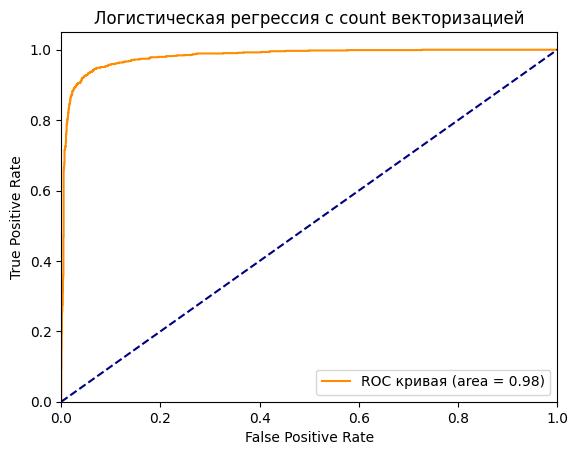


ROC-AUC для модели: Логистическая регрессия с TF-IDF векторизацией

ROC AUC=0.977


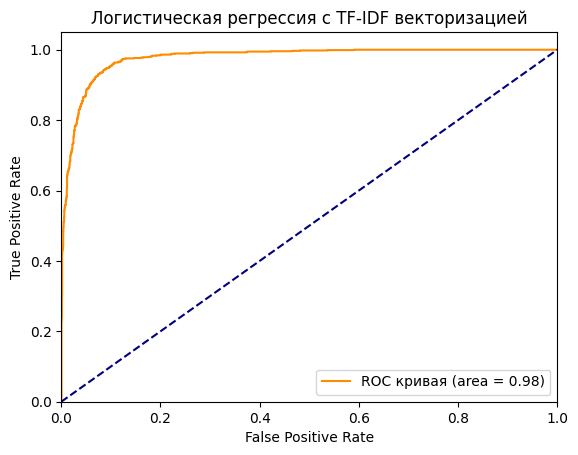

In [16]:
logreg_model_count = LogisticRegression(random_state=42)
logreg_model_count.fit(x_train_count_vec, y_train)
calculate_roc_auc(logreg_model_count.predict_proba(x_test_count_vec)[:, 1], model_name='Логистическая регрессия с count векторизацией')
logreg_model_tfidf = LogisticRegression(random_state=42)
logreg_model_tfidf.fit(x_train_tfidf_vec, y_train)
calculate_roc_auc(logreg_model_tfidf.predict_proba(x_test_tfidf_vec)[:, 1], model_name='Логистическая регрессия с TF-IDF векторизацией')

# Случайный лес


ROC-AUC для модели: Случайный лес с count векторизацией

ROC AUC=0.978


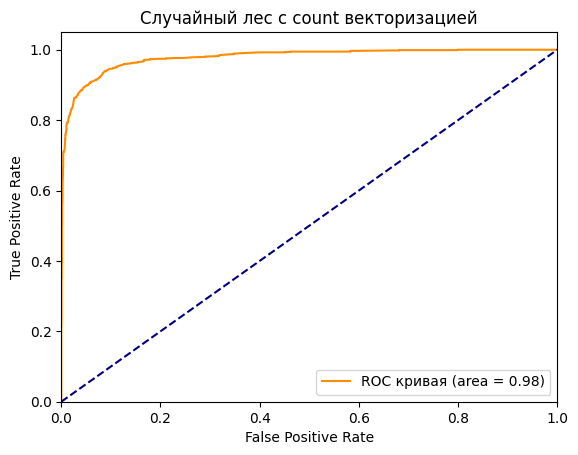


ROC-AUC для модели: Случайный лес с TF-IDF векторизацией

ROC AUC=0.982


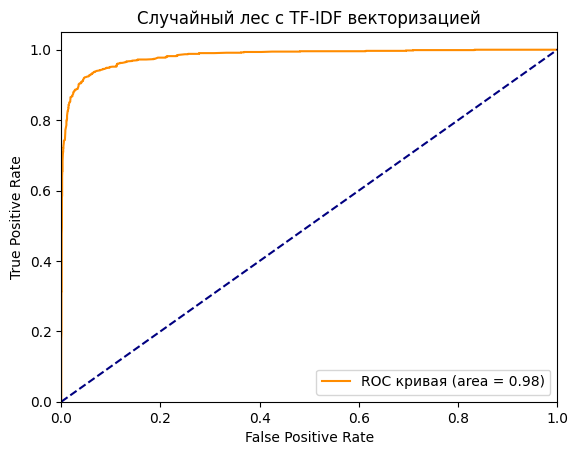

In [17]:
rf_model_count = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_count.fit(x_train_count_vec, y_train)
calculate_roc_auc(rf_model_count.predict_proba(x_test_count_vec)[:, 1],
                  model_name='Случайный лес с count векторизацией')
rf_model_tfidf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_tfidf.fit(x_train_tfidf_vec, y_train)
calculate_roc_auc(rf_model_tfidf.predict_proba(x_test_tfidf_vec)[:, 1],
                  model_name='Случайный лес с TF-IDF векторизацией')

# Градиентный бустинг


ROC-AUC для модели: Градиентный бустинг с count векторизацией

ROC AUC=0.971


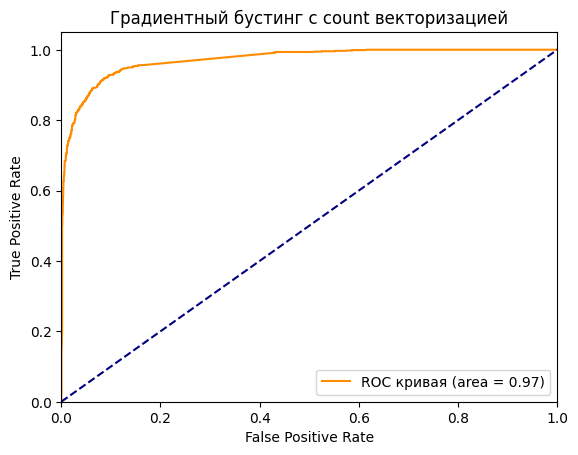


ROC-AUC для модели: Градиентный бустинг с TF-IDF векторизацией

ROC AUC=0.971


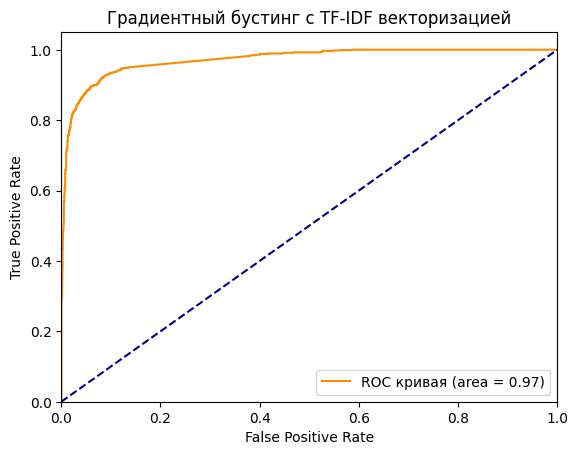

In [18]:
xgb_model_count = XGBClassifier(n_estimators=100, max_depth=6,
                                use_label_encoder=False, eval_metric='auc', random_state=42)
xgb_model_count.fit(x_train_count_vec, y_train)
calculate_roc_auc(xgb_model_count.predict_proba(x_test_count_vec)[:, 1],
                  model_name='Градиентный бустинг с count векторизацией')
xgb_model_tfidf = XGBClassifier(n_estimators=100, max_depth=6,
                                use_label_encoder=False, eval_metric='auc', random_state=42)
xgb_model_tfidf.fit(x_train_tfidf_vec, y_train)
calculate_roc_auc(xgb_model_tfidf.predict_proba(x_test_tfidf_vec)[:, 1],
                  model_name='Градиентный бустинг с TF-IDF векторизацией')

Позапуская модели с разными параметрами, разными random state с небольшим отрывом лидирует модель логистической регрессии с count векторизацией, к тому же она менее ресурсоемкая и лучше интерпретируется.

Поэтому будем использовать ее для предсказания тестовых данных

In [20]:
test_vec = count_vec.transform(df_test['text'])
predict_test = logreg_model_count.predict_proba(test_vec)[:, 1]
df_test['score'] = pd.DataFrame(predict_test)
name_dataset_score = 'test_score.csv'
df_test.to_csv('/'.join([path_to_dir, name_dataset_score]))

Получились достаточно неплохая модель, однако нельзя исключать возможности ее улучшить

Также не уверен что в правильном формате записал результат. В графе score указана вероятность письма быть спамом (изменяется в диапазоне от 0 до 1, где 0 - не спам, а 1 - спам)